In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xgboost
import xarray as xr
import numpy as np
from dask.distributed import Client
import dask
import dask_xgboost
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import time
from functools import partial
import multiprocessing
import os.path
from operator import is_not
from tsfresh import extract_relevant_features, extract_features, feature_extraction


In [3]:
processed_path = '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/'
path_to_labels = '/media/scottcha/E1/Data/OAPMLData/CleanedForecastsNWAC_CAIC_UAC.V1.2013-2020.csv'

In [4]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [5]:
#dask.config.set(scheduler='synchronous') 


In [6]:
#TODO set memory limit lower, then optimize chunks
#client=Client(n_workers=8, threads_per_worker=1 )
#client

In [7]:
def lookup_forecast_region(label_region):
    if label_region == 'Mt Hood':
        return 'Mt Hood'
    elif label_region == 'Olympics':
        return 'Olympics'
    elif label_region == 'Cascade Pass - Snoq. Pass':
        return 'Snoqualmie Pass'
    elif label_region == 'Cascade Pass - Stevens Pass':
        return 'Stevens Pass'
    elif label_region == 'Cascade East - Central':
        return 'WA Cascades East, Central'
    elif label_region == 'Cascade East - North':
        return 'WA Cascades East, North'
    elif label_region == 'Cascade East - South':
        return 'WA Cascades East, South'
    elif label_region == 'Cascade West - Central':
        return 'WA Cascades West, Central'
    elif label_region == 'Cascade West - North':
        return 'WA Cascades West, Mt Baker'
    elif label_region == 'Cascade West - South':
        return 'WA Cascades West, South'
    elif label_region == 'Abajo':
        return 'Abajos'
    elif label_region == 'Logan':
        return 'Logan'
    elif label_region == 'Moab':
        return 'Moab'
    elif label_region == 'Ogden':
        return 'Ogden'
    elif label_region == 'Provo':
        return 'Provo'
    elif label_region == 'Salt Lake':
        return 'Salt Lake'
    elif label_region == 'Skyline':
        return 'Skyline'
    elif label_region == 'Uintas':
        return 'Uintas'
    elif label_region == 'Grand Mesa':
        return 'Grand Mesa Zone'
    elif label_region == 'Sangre de Cristo':
        return 'Sangre de Cristo Range'
    elif label_region == 'Steamboat & Flat Tops':
        return 'Steamboat Zone'
    elif label_region == 'Front Range':
        return 'Front Range Zone'
    elif label_region == 'Vail & Summit County':
        return 'Vail Summit Zone'
    elif label_region == 'Sawatch Range':
        return 'Sawatch Zone'
    elif label_region == 'Aspen':
        return 'Aspen Zone'
    elif label_region == 'Northern San Juan':
        return 'North San Juan Mountains'
    elif label_region == 'Southern San Juan':
        return 'South San Juan Mountains'
    elif label_region == 'Gunnison':
        return 'Gunnison Zone'
    else:
        return 'Got region ' + label_region + ' but its an unknown region'

In [7]:
regions = {'Utah': ['Abajos', 'Logan', 'Moab', 'Ogden', 'Provo', 
           'Salt Lake', 'Skyline', 'Uintas'],  
           'Colorado': ['Grand Mesa Zone', 'Sangre de Cristo Range', 'Steamboat Zone', 'Front Range Zone',
           'Vail Summit Zone', 'Sawatch Zone', 'Aspen Zone', 
           'North San Juan Mountains', 'South San Juan Mountains', 'Gunnison Zone'],
           'Washington': ['Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass',
           'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South',
           'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South'
           ]}


In [8]:
#maintaining this as a dict since the arrays are ragged and its more efficient this way
region_zones = []
region_data = {}
for region in regions.keys():
    for r in regions[region]:
        region_zones.append(r)
        region_data[r] = xr.open_dataset(processed_path + '15-16/' + region + '/Region_' + r + '_20160101.nc')#, combine='nested', concat_dim='time')#, chunks={'season': 1, 'region': -1, 'latitude': 2, 'longitude': 2, 'var': -1, 'time': -1}).to_array()
    

In [9]:
regions

{'Utah': ['Abajos',
  'Logan',
  'Moab',
  'Ogden',
  'Provo',
  'Salt Lake',
  'Skyline',
  'Uintas'],
 'Colorado': ['Grand Mesa Zone',
  'Sangre de Cristo Range',
  'Steamboat Zone',
  'Front Range Zone',
  'Vail Summit Zone',
  'Sawatch Zone',
  'Aspen Zone',
  'North San Juan Mountains',
  'South San Juan Mountains',
  'Gunnison Zone'],
 'Washington': ['Mt Hood',
  'Olympics',
  'Snoqualmie Pass',
  'Stevens Pass',
  'WA Cascades East, Central',
  'WA Cascades East, North',
  'WA Cascades East, South',
  'WA Cascades West, Central',
  'WA Cascades West, Mt Baker',
  'WA Cascades West, South']}

In [9]:
region_data['Olympics']

<xarray.Dataset>
Dimensions:                                               (latitude: 10, longitude: 15, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] 2016-01-01
  * latitude                                              (latitude) float64 47.51 ... 48.04
  * longitude                                             (longitude) float64 -123.9 ... -123.0
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 ...
    GUST_surface_min                                      (time, latitude, longitude) float64 ...
    HGT_10mb_min                                          (time, latitude, longitude) float64 ...
    TMP_10mb_min                                          (time, latitude, longitude) float64 ...
    RH_10mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_10mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_10mb_min                                         (time, latitude, longitude) float64 ...
    HGT_20mb_min                                          (time, latitude, longitude) float64 ...
    TMP_20mb_min                                          (time, latitude, longitude) float64 ...
    RH_20mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_20mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_20mb_min                                         (time, latitude, longitude) float64 ...
    HGT_30mb_min                                          (time, latitude, longitude) float64 ...
    TMP_30mb_min                                          (time, latitude, longitude) float64 ...
    RH_30mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_30mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_30mb_min                                         (time, latitude, longitude) float64 ...
    HGT_50mb_min                                          (time, latitude, longitude) float64 ...
    TMP_50mb_min                                          (time, latitude, longitude) float64 ...
    RH_50mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_50mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_50mb_min                                         (time, latitude, longitude) float64 ...
    HGT_70mb_min                                          (time, latitude, longitude) float64 ...
    TMP_70mb_min                                          (time, latitude, longitude) float64 ...
    RH_70mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_70mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_70mb_min                                

In [10]:
labels = pd.read_csv(path_to_labels, low_memory=False,
        dtype={'Day1Danger_OctagonAboveTreelineEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorth': 'object',
               'Day1Danger_OctagonAboveTreelineNorthEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorthWest': 'object',
               'Day1Danger_OctagonAboveTreelineSouth': 'object',
               'Day1Danger_OctagonAboveTreelineSouthEast': 'object',
               'Day1Danger_OctagonAboveTreelineSouthWest': 'object',
               'Day1Danger_OctagonAboveTreelineWest': 'object',
               'Day1Danger_OctagonBelowTreelineEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorth': 'object',
               'Day1Danger_OctagonBelowTreelineNorthEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorthWest': 'object',
               'Day1Danger_OctagonBelowTreelineSouth': 'object',
               'Day1Danger_OctagonBelowTreelineSouthEast': 'object',
               'Day1Danger_OctagonBelowTreelineSouthWest': 'object',
               'Day1Danger_OctagonBelowTreelineWest': 'object',
               'Day1Danger_OctagonNearTreelineEast': 'object',
               'Day1Danger_OctagonNearTreelineNorth': 'object',
               'Day1Danger_OctagonNearTreelineNorthEast': 'object',
               'Day1Danger_OctagonNearTreelineNorthWest': 'object',
               'Day1Danger_OctagonNearTreelineSouth': 'object',
               'Day1Danger_OctagonNearTreelineSouthEast': 'object',
               'Day1Danger_OctagonNearTreelineSouthWest': 'object',
               'Day1Danger_OctagonNearTreelineWest': 'object',
               'SpecialStatement': 'object',
               'image_paths': 'object',
               'image_types': 'object',
               'image_urls': 'object'})
date_col = 'Day1Date'
region_col = 'UnifiedRegion'
labels['parsed_date'] = pd.to_datetime(labels[date_col], format='%Y%m%d')
parsed_date_col = 'parsed_date'
metadata_cols = [date_col, region_col]
label_cols = ['Day1DangerBelowTreeline', 'Day1DangerNearTreeline', 'Day1DangerAboveTreeline']
labels[region_col] = labels.apply(lambda x : lookup_forecast_region(x[region_col]), axis=1)
labels = labels[labels[region_col]!='Unknown region']

In [11]:
labels = labels[labels[region_col].isin(region_zones)]

In [13]:
labels[parsed_date_col].value_counts()

2017-03-24    28
2017-02-23    28
2017-01-04    28
2018-02-19    28
2016-03-19    28
              ..
2020-01-19     1
2019-01-20     1
2019-03-01     1
2019-01-27     1
2020-01-17     1
Name: parsed_date, Length: 1094, dtype: int64

In [14]:
labels[region_col].value_counts()

WA Cascades East, South       885
WA Cascades West, Mt Baker    774
WA Cascades West, South       762
Snoqualmie Pass               760
Olympics                      760
WA Cascades West, Central     757
Stevens Pass                  755
Front Range Zone              750
Grand Mesa Zone               750
WA Cascades East, Central     749
Sangre de Cristo Range        744
Steamboat Zone                743
Vail Summit Zone              741
Sawatch Zone                  741
Aspen Zone                    740
Mt Hood                       738
Gunnison Zone                 736
Salt Lake                     717
Ogden                         694
Provo                         690
South San Juan Mountains      682
North San Juan Mountains      679
WA Cascades East, North       602
Uintas                        541
Logan                         529
Skyline                       449
Moab                          406
Abajos                        228
Name: UnifiedRegion, dtype: int64

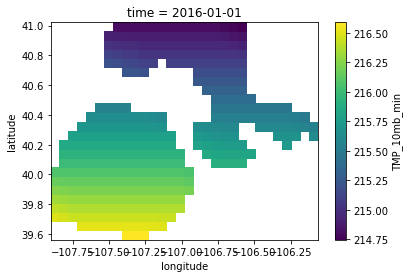

In [15]:
#this demonstrates wihtin a region how much data we have versus masked out areas
region_data['Steamboat Zone'].TMP_10mb_min.plot()

In [16]:
#find union of all lat/lon/region to just grids with values
#the process to filter the lat/lon is expensive but we need to do it here (30 seconds per region)
#as the helps the batch process select relevant data
lat_lon_union = pd.DataFrame()
for r in region_data.keys():
    print(r)
    region_df = region_data[r].stack(lat_lon = ('latitude', 'longitude')).lat_lon.to_dataframe()
    tmp_df = pd.DataFrame.from_records(region_df['lat_lon'], columns=['latitude', 'longitude'])
    indexes_to_drop = []
    for index, row in tmp_df.iterrows():
        #TODO: there might be a more efficient way than doing this one by one?
        if 0 == np.count_nonzero(region_data[r].to_array().sel(latitude=row['latitude'], longitude=row['longitude']).stack(time_var = ('time', 'variable')).dropna(dim='time_var', how='all').values):
            indexes_to_drop.append(index)
    tmp_df.drop(indexes_to_drop, axis=0, inplace=True)
    tmp_df[region_col] = r
    lat_lon_union = pd.concat([lat_lon_union, tmp_df])

Abajos
Logan
Moab
Ogden
Provo
Salt Lake
Skyline
Uintas
Grand Mesa Zone
Sangre de Cristo Range
Steamboat Zone
Front Range Zone
Vail Summit Zone
Sawatch Zone
Aspen Zone
North San Juan Mountains
South San Juan Mountains
Gunnison Zone
Mt Hood
Olympics
Snoqualmie Pass
Stevens Pass
WA Cascades East, Central
WA Cascades East, North
WA Cascades East, South
WA Cascades West, Central
WA Cascades West, Mt Baker
WA Cascades West, South


In [17]:
lat_lon_union.head()

,latitude,longitude,UnifiedRegion
1,37.704348,-109.776536,Abajos
2,37.704348,-109.715084,Abajos
7,37.765217,-109.837989,Abajos
8,37.765217,-109.776536,Abajos
9,37.765217,-109.715084,Abajos


In [18]:
#cache the data
lat_lon_union.to_csv(processed_path + 'lat_lon_union.csv')

In [12]:
lat_lon_union = pd.read_csv(processed_path + 'lat_lon_union.csv',float_precision='round_trip')

In [13]:
lat_lon_union.shape

(3991, 4)

In [14]:
lat_lon_union = lat_lon_union.set_index(region_col, drop=False).join(labels.set_index(region_col, drop=False), how='left', lsuffix='left', rsuffix='right')

In [13]:
lat_lon_union.shape

(2833560, 299)

In [13]:
del labels

In [15]:
def date_to_season(d):
    if d >= np.datetime64('2014-11-01') and d <= np.datetime64('2015-04-30'):
        return (np.datetime64('2014-11-01'), '14-15')
    elif d >= np.datetime64('2015-11-01') and d <= np.datetime64('2016-04-30'):
        return (np.datetime64('2015-11-01'), '15-16')
    elif d >= np.datetime64('2016-11-01') and d <= np.datetime64('2017-04-30'):
        return (np.datetime64('2016-11-01'), '16-17')
    elif d >= np.datetime64('2017-11-01') and d <= np.datetime64('2018-04-30'):
        return (np.datetime64('2017-11-01'), '17-18')
    elif d >= np.datetime64('2018-11-01') and d <= np.datetime64('2019-04-30'):
        return (np.datetime64('2018-11-01'), '18-19')
    elif d >= np.datetime64('2019-11-01') and d <= np.datetime64('2020-04-30'):
        return (np.datetime64('2019-11-01'), '19-20')
    else:
        print('Unknown season ' + str(d))
        return (-1,'Unknown')
    

In [16]:
#earliest_data, season = date_to_season(np.datetime64('2015-12-11'))

In [17]:
#remove unnecessary dimensions (like region)
#for k in region_data.keys():
#    region_data[k] = region_data[k].squeeze()

In [16]:
def get_state_for_region(region):
    for k in regions.keys():
        #print('on k ' + k)
        #print('with regions: ' + regions[k])
        if region in regions[k]:
            return k
    
    raise Exception('No region with name ' + region)

In [17]:
def create_filename_list(region, end_date, lookback_days):
    earliest_data, season = date_to_season(end_date)
    if earliest_data == -1:
        return None
    state = get_state_for_region(region)
    filenames = []
    reg = region
    for i in range(lookback_days):
        d = np.datetime64(end_date) - np.timedelta64(i, 'D')
        if d < earliest_data:
            break #no more data
        filenames.insert(0,processed_path + '/' + season + '/' + state + '/Region_' + reg + '_' + pd.to_datetime(d).strftime('%Y%m%d') + '.nc')
    return filenames
        
        

In [18]:
def get_data_serial(region, lat, lon, lookback_days, date):
    data = []    
    filenames = create_filename_list(region, date, lookback_days) 
    if filenames is None:
        return None, None
    error_files = []
    for f in filenames:      
        if os.path.isfile(f): #sometimes the file is missing
            try:
                data.append(xr.open_dataset(f)) 
            except OSError as err:
                error_files.append(f)
                print('Error file: ' + f)
        else:
            print('Skipped file: ' + f)
    try:
        tmp_ds = xr.concat(data, dim='time')
    except ValueError as err:
        print('Error ' + format(err) + ' On region: ' + region + ' and lat/lon: ' + str(lat) + '/' + str(lon) + ' and date: ' + str(date))
        return None, error_files
    
    tmp2 = tmp_ds.sel(latitude=lat, longitude=lon, method='nearest')
    date_values_pd = pd.date_range(date - np.timedelta64(lookback_days-1, 'D'), periods=lookback_days, freq='D')
    #reindex should fill missing values with NA
    tmp2 = tmp2.reindex({'time': date_values_pd})
    tmp2 = tmp2.reset_index(dims_or_levels='time', drop=True).load()
    #print("loaded data")
    return tmp2, error_files

In [19]:
def process_sample(iter_tuple, lookback_days):
    row = iter_tuple[1]
    d = row[parsed_date_col] #row is a tuple which, 1 is the row
    
    lat = row['latitude']
    lon = row['longitude']
    reg = row[region_col]            
    ds, error_files = get_data_serial(reg, lat, lon, lookback_days, d)
    if ds is None:
        return None, error_files
    
    #print("actual data")
    if ds.time.shape[0] != lookback_days:    
        print('Need to drop! Error, incorrect shape on time ' + str(d))
    return (ds, error_files)



def get_xr_batch(labels, lookback_days=14, batch_size=64, y_column='Day1DangerAboveTreeline', n_jobs=-1):
    labels_data = labels
    
    X = None     
    y = None 

    first = True   
    num_in_place = 0
    error_files = []
    while num_in_place < batch_size:
        if not first:
            #if we didn't meet the full batch size 
            #continue appending until its full
            #if num_in_place % 5 == 0:
            print('Filling remaining have ' + str(num_in_place))
            sample_size = batch_size-num_in_place
            if sample_size < 4:
                sample_size = 4
        else: 
            sample_size = batch_size
        
        #get 1/4 of the data from 'High' and 1/4 from low
        #this is basically a naive oversampling strategy since Low/High 
        #populations are much smaller that moderate/considerable
        #TODO: add Extreme in (or possibly make it high)
        batch_lookup_low = labels_data[labels_data[y_column]=='Low'].sample(int(sample_size/4), random_state=1)
        batch_lookup_moderate = labels_data[labels_data[y_column]=='Moderate'].sample(int(sample_size/4), random_state=1)
        batch_lookup_considerable = labels_data[labels_data[y_column]=='Considerable'].sample(int(sample_size/4), random_state=1)
        batch_lookup_high = labels_data[labels_data[y_column]=='High'].sample(int(sample_size/4), random_state=1)
        
        #remove moderate and considerable, keeping high and low to oversample them
        labels_data = labels_data.drop(batch_lookup_moderate.index, axis=0)
        labels_data = labels_data.drop(batch_lookup_considerable.index, axis=0)
        
        #sample frac=1 causes the data to be shuffled
        batch_lookup = pd.concat([batch_lookup_low,batch_lookup_moderate,batch_lookup_considerable,batch_lookup_high]).sample(frac=1)
        #print('lookup shape: ' + str(batch_lookup.shape))
        batch_lookup.reset_index(inplace=True, drop=True)
        
        func = partial(process_sample, lookback_days=lookback_days)        
        ret_tuple = Parallel(n_jobs=n_jobs, backend="multiprocessing")(map(delayed(func), batch_lookup.iterrows()))
        
        data = [x[0] for x in ret_tuple]
        [error_files.append([x[1] for x in ret_tuple])]
        
        #for _, row in batch_lookup.iterrows():
            #print('On: ' + str(_))
           
            
            #
            #print(date_values_pd)
            #ds = ds.reindex({'time': date_values_pd})
            
            #data = ds.sel(latitude=lat, longitude=lon).load()
            
            #reset the time index so we can align when concating
            #data = data.reset_index(dims_or_levels='time', drop=True)
            #if ds.time.shape[0] != lookback_days:    
            #    print('Error, incorrect shape on time ' + str(d))
            #    batch_lookup = batch_lookup.drop(_, axis=0)
            #    continue

            #this is a serious perf penalty, need to figure out a better way to do this
            #while keeping X and y aligned            
            #tmp = data.to_array().values.copy()            
            #tmp[tmp==0] = np.nan #in some cases there is only 0 data, setting 0 to nan to filter
            #if np.isnan(tmp).all():
            #    print('**In cleanup')
            #    #clean up any values which are all nan
            #    batch_lookup = batch_lookup.drop(_, axis=0)
            #    continue
            
            #data = data.drop_dims(['region', 'season'])
            #if first:
            #    X = ds
            #    first = False        
            #else:
            #    X = xr.concat([X, ds], dim='sample')
        #remove any None values and corresponding labels
        #usually from an error in the dataset 

        #print('data has len: ' + str(len(data)))
        #to_delete = []
        #delete backwards so we can delete by index
        for i in reversed(range(len(data))):
            #print('on i: ' + str(i))
            if data[i] is None:
                print('deleting ' + str(i))
                del data[i]
                batch_lookup = batch_lookup.drop(i, axis=0)
                
        
        #for d in sorted(to_delete, reverse=True):
        #    print('deleting ' + str(d))
        #    del data[d]
            
        for f in data:
            if f is None:
                print('Still have none in data')
            
        if first and len(data) > 0:                            
            X = xr.concat(data, dim='sample', coords='all', compat='override')   
            y = batch_lookup
            first = False            
        elif not first and len(data) > 0:
            data.insert(0, X)
            X = xr.concat(data, dim='sample', coords='all', compat='override') 
            y = pd.concat([y, batch_lookup], axis=0)
            
        num_in_place = y.shape[0]
        #print('Num: ' + str(num_in_place))
                
    y = y.reset_index(drop=True)
            
    return X, y, labels_data, error_files







In [20]:
date_min = np.datetime64('2015-11-01')
date_max = np.datetime64('2019-04-30')
train_date_cutoff = np.datetime64('2018-11-01')


In [21]:
labels_data_union = lat_lon_union[lat_lon_union[parsed_date_col] >= date_min]
labels_data_union = labels_data_union[labels_data_union[parsed_date_col] <= date_max]
#copy so we can delete the overall data and only keep the filtered
labels_data_train = labels_data_union[labels_data_union[parsed_date_col] <= train_date_cutoff].copy()
labels_data_test = labels_data_union[labels_data_union[parsed_date_col] > train_date_cutoff].copy()


In [22]:
labels_data_train.reset_index(inplace=True)
labels_data_test.reset_index(inplace=True)

In [22]:
labels_data_train.shape

(1740900, 300)

In [28]:
del lat_lon_union

In [31]:
import gc
gc.collect()

100

In [32]:
labels_data_train[region_col].value_counts()

Steamboat Zone                153900
Front Range Zone              153340
North San Juan Mountains      131670
WA Cascades West, South       131264
WA Cascades East, Central     116032
WA Cascades East, North       114240
South San Juan Mountains      105152
WA Cascades West, Central      86016
WA Cascades East, South        73024
Gunnison Zone                  66156
Sangre de Cristo Range         65116
WA Cascades West, Mt Baker     63474
Grand Mesa Zone                56952
Vail Summit Zone               53040
Aspen Zone                     48492
Sawatch Zone                   47250
Olympics                       46592
Skyline                        46138
Uintas                         43290
Logan                          30420
Ogden                          30360
Salt Lake                      15538
Mt Hood                        14336
Snoqualmie Pass                12992
Provo                          12236
Stevens Pass                   11200
Moab                            8120
A

In [60]:
#with parallel file open but not parallel process sample
#%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 14, 64)

CPU times: user 11min 6s, sys: 1min 50s, total: 12min 56s
Wall time: 13min 29s


In [90]:
#8 cores
#%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 14, 64)

CPU times: user 16.1 s, sys: 3.17 s, total: 19.2 s
Wall time: 1min 47s


In [46]:
data = get_xr_batch(labels_data_train, 14, 12, n_jobs=14)

In [48]:
len(data)

12

In [53]:
e = []

In [54]:
[e.append(x[1]) for x in data]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [23]:
def get_multi_batches(labels, num_batches=10, batch_size=128, lookback_days=14, n_jobs=14):
    

    remaining_labels_train = labels
    error_files = []
    X = None
    y = None
    first = True

    for i in range(num_batches):
        print('On ' + str(i) + ' of ' + str(num_batches))
        X_b, y_b, remaining_labels_train, error_files_b = get_xr_batch(remaining_labels_train, lookback_days, batch_size, n_jobs=n_jobs)
        error_files.append(error_files_b)
        if first:                            
            X = X_b  
            y = y_b
            first = False            
        else:
            X = xr.concat([X, X_b], dim='sample', coords='all', compat='override') 
            y = pd.concat([y, y_b], axis=0)
    y.reset_index(inplace=True)
    return X, y, remaining_labels_train, error_files

#14 cores, batch size of 12 is the max I can generate at once on my 48 gb machine
#though memory goes way down after returning so can concat these in multiple steps
#%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 180, 12)

In [28]:
X_train

<xarray.Dataset>
Dimensions:                                               (sample: 1295, time: 14)
Coordinates:
    longitude                                             (sample) float64 -120.9 ... -121.9
    latitude                                              (sample) float64 47.53 ... 48.98
Dimensions without coordinates: sample, time
Data variables:
    LANDN_surface_avg                                     (time, sample) float64 1.0 ... nan
    LANDN_surface_min                                     (time, sample) float64 1.0 ... nan
    VIS_surface_max                                       (time, sample) float64 2.41e+04 ... nan
    VIS_surface_min                                       (time, sample) float64 2.41e+04 ... nan
    VIS_surface_avg                                       (time, sample) float64 2.41e+04 ... nan
    LANDN_surface_max                                     (time, sample) float64 1.0 ... nan
    UGRD_planetaryboundarylayer_min                       (sample, time) float64 -1.738 ... 0.4787
    VGRD_planetaryboundarylayer_min                       (sample, time) float64 -0.07934 ... -1.205
    VRATE_planetaryboundarylayer_min                      (sample, time) float64 0.0 ... 15.09
    GUST_surface_min                                      (sample, time) float64 1.277 ... 0.9721
    HGT_1mb_min                                           (sample, time) float64 4.708e+04 ... 4.628e+04
    TMP_1mb_min                                           (sample, time) float64 264.1 ... 255.7
    RH_1mb_min                                            (sample, time) float64 0.00128 ... 0.00126
    UGRD_1mb_min                                          (sample, time) float64 31.85 ... 32.21
    VGRD_1mb_min                                          (sample, time) float64 4.911 ... 5.867
    O3MR_1mb_min                                          (sample, time) float64 4.547e-06 ... 5.089e-06
    HGT_2mb_min                                           (sample, time) float64 4.178e+04 ... 4.121e+04
    TMP_2mb_min                                           (sample, time) float64 255.9 ... 243.0
    RH_2mb_min                                            (sample, time) float64 0.0014 ... 0.007371
    UGRD_2mb_min                                          (sample, time) float64 24.16 ... 15.66
    VGRD_2mb_min                                          (sample, time) float64 3.888 ... 6.975
    O3MR_2mb_min                                          (sample, time) float64 8.026e-06 ... 8.937e-06
    HGT_3mb_min                                           (sample, time) float64 3.881e+04 ... 3.84e+04
    TMP_3mb_min                                           (sample, time) float64 244.6 ... 231.1
    RH_3mb_min                                            (sample, time) float64 0.008 ... 0.0409
    UGRD_3mb_min                                          (sample, time) float64 17.17 ... 5.846
    VGRD_3mb_min                                          (sample, time) float64 3.507 ... 6.39
    O3MR_3mb_min                                          (sample, time) float64 1.038e-05 ... 1.111e-05
    HGT_5mb_min                                           (sample, time) float64 3.526e+04 ... 3.501e+04
    TMP_5mb_min                                           (sample, time) float64 231.5 ... 222.8
    RH_5mb_min                                            (sample, time) float64 0.06022 ... 0.1971
    UGRD_5mb_min                                          (sample, time) float64 7.564 ... 1.517
    VGRD_5mb_min                                          (sample, time) float64 1.738 ... 6.09
    O3MR_5mb_min                                          (sample, time) float64 1.309e-05 ... 1.293e-05
    HGT_7mb_min                                           (sample, time) float64 3.301e+04 ... 3.283e+04
    TMP_7mb_min                                           (sample, time) float64 225.6 ... 220.7
    RH_7mb_min                                            (sample, time) 

In [23]:
X_train.to_array().values.shape

(1131, 14, 128)

In [24]:
y_train.head()

,UnifiedRegion,Unnamed: 0,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,...,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,BottomLineSummary,Day1WarningText,Day2WarningText,parsed_date
0,North San Juan Mountains,364,38.130435,-107.502793,North San Juan Mountains,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2016-02-02
1,North San Juan Mountains,295,38.008696,-106.949721,North San Juan Mountains,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2016-12-16
2,Sangre de Cristo Range,124,37.339130,-105.229050,Sangre de Cristo Range,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2018-01-05
3,Steamboat Zone,123,39.834783,-107.687151,Steamboat Zone,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2015-11-26
4,Logan,73,41.904348,-111.620112,Logan,no-data,no-data,no-data,no-data,no-data,...,0,0,full/9cf1e128b87ef96639085ca2ce1650502b63e2c5....,"Forecast,PersistentSlab,WindSlab",https://utahavalanchecenter.org/sites/default/...,no-data,no-data,no-data,no-data,2018-01-11


In [29]:
y_train['Day1DangerAboveTreeline'].shape

(1295,)

In [27]:
labels_data_train.shape

(1740900, 300)

In [28]:
remaining_labels_train.shape

(1740836, 300)

In [29]:
X_train.nbytes

14039792

In [24]:
%time X_train, y_train, remaining_labels_train, error_files_train = get_multi_batches(labels_data_train, num_batches=10, lookback_days=180, batch_size=12)

On 0 of 10


/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//17-18/Washington/Region_WA Cascades West, Central_20171101.nc
Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//16-17/Colorado/Region_Steamboat Zone_20161102.nc
Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//17-18/Utah/Region_Skyline_20171103.nc
Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//16-17/Colorado/Region_Steamboat Zone_20161211.nc
Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//17-18/Colorado/Region_Sangre de Cristo Range_20171217.nc
Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//16-17/Colorado/Region_Steamboat Zone_20170117.nc
Skipped file: /media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered//16-17/Colorado/Region_Steamboat Zone_20170120.nc


Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/scottcha/anaconda3/envs/pangeo

KeyboardInterrupt: 

In [25]:
%time X_test, y_test, remaining_labels_test, error_files_test = get_multi_batches(labels_data_test, num_batches=5, lookback_days=14, batch_size=128)

On 0 of 5


/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

On 1 of 5


/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

On 2 of 5


/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

On 3 of 5


/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

On 4 of 5


/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This

CPU times: user 2min 44s, sys: 38.3 s, total: 3min 22s
Wall time: 20min 10s


In [75]:
y_train['Day1DangerAboveTreeline']

0               Low
1          Moderate
2               Low
3              High
4              High
           ...     
638        Moderate
639        Moderate
640    Considerable
641             Low
642            High
Name: Day1DangerAboveTreeline, Length: 643, dtype: object

In [32]:
y_test.shape

(640, 301)

In [27]:
def clean_double_space(X_to_clean):
    print('On clean_double_space')
    for x in X_to_clean.data_vars.keys():
        if '__' in x:
            new_x = x.replace('__', '_')
            X_to_clean = X_to_clean.rename_vars({x:new_x})
    return X_to_clean

In [28]:
def xr_batch_to_tsfresh_df(xr_batch):
    print('On xr_batch_to_tsfresh_df')
    xr_batch = xr_batch.to_array()
    xr_batch = xr_batch.dropna(dim='variable', how='all')
    stacked = xr_batch.stack(tsdata=('sample', 'time', 'variable')).to_dataframe(name='value').iloc[:,[-1]]
    stacked.columns = ['value']
    stacked.reset_index(inplace=True)
    stacked.columns = ['id', 'time', 'kind', 'value']
    stacked.dropna(how='any', inplace=True)
    return stacked

In [43]:
def prepare_batch(X, y, y_column='Day1DangerAboveTreeline', known_relevant_features=None, n_jobs=14):
    X = clean_double_space(X)
    print('On interpolate_na')
    X = X.interpolate_na('time')
    X_tsfresh = xr_batch_to_tsfresh_df(X)
    assert(np.isnan(X_tsfresh['value']).any()==False)
    X_tsfresh = X_tsfresh[['id', 'time', 'kind', 'value']]
    
    feature_parameters = None
    if known_relevant_features is not None:       
        feature_parameters = feature_extraction.settings.from_columns(known_relevant_features)
    
    relevant_features =[]
    stride = 75   
    #break this in to batches of variables to help is scale better in memory
    unique_kind = X_tsfresh['kind'].unique()
            
    for i in range(0,len(unique_kind),stride):
        print('On i: ' + str(i) + ' of ' + str(len(unique_kind)))
        #not every variable has a sample data so map labels to the data which does exist for that variable
        subset = X_tsfresh[X_tsfresh['kind'].isin(unique_kind[i:i+stride])]
        #return subset, unique_kind
        if feature_parameters is None:
            relevant_features.append( extract_relevant_features(subset, y[y_column].iloc[subset.id.unique()], column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=n_jobs))
        else:
            relevant_features.append( extract_features(subset, kind_to_fc_parameters=feature_parameters, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=n_jobs))
            
    
    relevant_features_df = pd.concat(relevant_features, axis=1)
    return relevant_features_df

In [122]:
#y_train.reset_index(inplace=True)

In [30]:
%time X_train_df = prepare_batch(X_train, y_train)

On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:12<00:00,  3.61s/it]


On i: 75 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:27<00:00,  3.82s/it]


On i: 150 of 1125


Feature Extraction: 100%|██████████| 70/70 [05:13<00:00,  4.48s/it] 


On i: 225 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:46<00:00,  4.10s/it] 


On i: 300 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:24<00:00,  3.78s/it]


On i: 375 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:28<00:00,  3.84s/it]


On i: 450 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:28<00:00,  3.84s/it]


On i: 525 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:40<00:00,  4.01s/it] 


On i: 600 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:37<00:00,  3.96s/it]


On i: 675 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:10<00:00,  3.58s/it]


On i: 750 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:40<00:00,  4.01s/it] 


On i: 825 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:33<00:00,  3.91s/it] 


On i: 900 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:43<00:00,  4.05s/it] 


On i: 975 of 1125


Feature Extraction: 100%|██████████| 70/70 [04:40<00:00,  4.01s/it] 


On i: 1050 of 1125


Feature Extraction: 100%|██████████| 70/70 [01:52<00:00,  1.61s/it]


CPU times: user 58min 13s, sys: 8min 11s, total: 1h 6min 24s
Wall time: 2h 1min 30s


In [44]:
%time X_test_df = prepare_batch(X_test, y_test, known_relevant_features=X_train_df)

On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:26<00:00,  2.10s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:09<00:00,  1.86s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:45<00:00,  2.36s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:25<00:00,  2.08s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:16<00:00,  1.95s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:12<00:00,  1.90s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:20<00:00,  2.01s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:41<00:00,  2.31s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:28<00:00,  2.12s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:28<00:00,  2.11s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:26<00:00,  2.09s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:29<00:00,  2.14s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:47<00:00,  2.40s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [02:35<00:00,  2.22s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


CPU times: user 24min 6s, sys: 2min 55s, total: 27min 1s
Wall time: 50min 9s


In [46]:
X_test_df.to_csv('/media/scottcha/Data/Temp/testing_tsfresh_data.csv')
y_test.to_csv('/media/scottcha/Data/Temp/y_test.csv')
X_train_df.to_csv('/media/scottcha/Data/Temp/training_tsfresh_data.csv')
y_train.to_csv('/media/scottcha/Data/Temp/y_train.csv')

In [ ]:
#from tsfresh import extract_relevant_features
#relevant_features =[]
#stride = 75
#TODO: make this more gracefully end on last stride
#break this in to batches of variables to help is scale better in memory
#for i in range(0,len(tsfresh_data['kind'].unique()),stride):
#    print('On i: ' + str(i))
    #not every variable has a sample data so map labels to the data which does exist for that variable
#    subset = tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].unique()[i:i+stride])]
    
    #relevant_features.append( extract_relevant_features(subset, y_train['Day1DangerAboveTreeline'][subset.id.unique()], column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))

In [71]:
y_train['Day1DangerAboveTreeline']

0               Low
1          Moderate
2               Low
3              High
4              High
           ...     
638        Moderate
639        Moderate
640    Considerable
641             Low
642            High
Name: Day1DangerAboveTreeline, Length: 643, dtype: object

In [102]:
a.id.unique()

array([   0,    1,    2, ..., 1292, 1293, 1294])

In [90]:
X_train

<xarray.Dataset>
Dimensions:                                               (sample: 1295, time: 14)
Coordinates:
    longitude                                             (sample) float64 -120.9 ... -121.9
    latitude                                              (sample) float64 47.53 ... 48.98
Dimensions without coordinates: sample, time
Data variables:
    LANDN_surface_avg                                     (time, sample) float64 1.0 ... nan
    LANDN_surface_min                                     (time, sample) float64 1.0 ... nan
    VIS_surface_max                                       (time, sample) float64 2.41e+04 ... nan
    VIS_surface_min                                       (time, sample) float64 2.41e+04 ... nan
    VIS_surface_avg                                       (time, sample) float64 2.41e+04 ... nan
    LANDN_surface_max                                     (time, sample) float64 1.0 ... nan
    UGRD_planetaryboundarylayer_min                       (sample, time) float64 -1.738 ... 0.4787
    VGRD_planetaryboundarylayer_min                       (sample, time) float64 -0.07934 ... -1.205
    VRATE_planetaryboundarylayer_min                      (sample, time) float64 0.0 ... 15.09
    GUST_surface_min                                      (sample, time) float64 1.277 ... 0.9721
    HGT_1mb_min                                           (sample, time) float64 4.708e+04 ... 4.628e+04
    TMP_1mb_min                                           (sample, time) float64 264.1 ... 255.7
    RH_1mb_min                                            (sample, time) float64 0.00128 ... 0.00126
    UGRD_1mb_min                                          (sample, time) float64 31.85 ... 32.21
    VGRD_1mb_min                                          (sample, time) float64 4.911 ... 5.867
    O3MR_1mb_min                                          (sample, time) float64 4.547e-06 ... 5.089e-06
    HGT_2mb_min                                           (sample, time) float64 4.178e+04 ... 4.121e+04
    TMP_2mb_min                                           (sample, time) float64 255.9 ... 243.0
    RH_2mb_min                                            (sample, time) float64 0.0014 ... 0.007371
    UGRD_2mb_min                                          (sample, time) float64 24.16 ... 15.66
    VGRD_2mb_min                                          (sample, time) float64 3.888 ... 6.975
    O3MR_2mb_min                                          (sample, time) float64 8.026e-06 ... 8.937e-06
    HGT_3mb_min                                           (sample, time) float64 3.881e+04 ... 3.84e+04
    TMP_3mb_min                                           (sample, time) float64 244.6 ... 231.1
    RH_3mb_min                                            (sample, time) float64 0.008 ... 0.0409
    UGRD_3mb_min                                          (sample, time) float64 17.17 ... 5.846
    VGRD_3mb_min                                          (sample, time) float64 3.507 ... 6.39
    O3MR_3mb_min                                          (sample, time) float64 1.038e-05 ... 1.111e-05
    HGT_5mb_min                                           (sample, time) float64 3.526e+04 ... 3.501e+04
    TMP_5mb_min                                           (sample, time) float64 231.5 ... 222.8
    RH_5mb_min                                            (sample, time) float64 0.06022 ... 0.1971
    UGRD_5mb_min                                          (sample, time) float64 7.564 ... 1.517
    VGRD_5mb_min                                          (sample, time) float64 1.738 ... 6.09
    O3MR_5mb_min                                          (sample, time) float64 1.309e-05 ... 1.293e-05
    HGT_7mb_min                                           (sample, time) float64 3.301e+04 ... 3.283e+04
    TMP_7mb_min                                           (sample, time) float64 225.6 ... 220.7
    RH_7mb_min                                            (sample, time) 

In [103]:
y_train['Day1DangerAboveTreeline'].iloc[a.id.unique()]

0          Moderate
1              High
2          Moderate
3               Low
4               Low
           ...     
126    Considerable
127    Considerable
128        Moderate
129             Low
130            High
Name: Day1DangerAboveTreeline, Length: 1294, dtype: object

In [109]:
len(a.id.unique())

1294

In [117]:
y_train['Day1DangerAboveTreeline'].iloc[a.id.unique()].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            121, 122, 123, 124, 125, 126, 127, 128, 129, 130],
           dtype='int64', length=1294)

In [118]:
y_train

,UnifiedRegion,Unnamed: 0,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,...,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,BottomLineSummary,Day1WarningText,Day2WarningText,parsed_date
0,"WA Cascades East, Central",157,47.507463,-120.927711,"WA Cascades East, Central",0-unlikely,2-very large,1-large,1,1,...,0,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2017-04-23
1,"WA Cascades West, South",129,46.253731,-121.710843,"WA Cascades West, South",no-data,no-data,no-data,no-data,no-data,...,0,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2016-01-16
2,"WA Cascades West, Central",236,48.223881,-121.409639,"WA Cascades West, Central",no-data,no-data,no-data,no-data,no-data,...,0,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2017-02-24
3,North San Juan Mountains,328,38.069565,-107.318436,North San Juan Mountains,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2017-01-19
4,North San Juan Mountains,209,37.886957,-107.441341,North San Juan Mountains,no-data,no-data,no-data,no-data,no-data,...,0,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2017-12-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Aspen Zone,74,39.286957,-106.519553,Aspen Zone,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2018-02-11
127,Front Range Zone,336,39.286957,-105.659218,Front Range Zone,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2018-04-09
128,North San Juan Mountains,305,38.008696,-106.335196,North San Juan Mountains,no-data,no-data,no-data,no-data,no-data,...,0,0,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2017-02-26
129,Sangre de Cristo Range,252,37.704348,-105.474860,Sangre de Cristo Range,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,no-data,2018-01-05


In [ ]:
y_train[y_column].iloc[subset.id.unique()]

In [125]:
%time X_test_df = prepare_batch(X_test, y_test, known_relevant_features=X_train_df)

On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:04<00:00, 14.05it/s]


On i: 75 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:03<00:00, 20.57it/s]


On i: 150 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:06<00:00, 10.50it/s]


On i: 225 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:10<00:00,  6.93it/s]


On i: 300 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:09<00:00,  7.22it/s]


On i: 375 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s]


On i: 450 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:05<00:00, 13.73it/s]


On i: 525 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:09<00:00,  7.31it/s]


On i: 600 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:08<00:00,  8.21it/s]


On i: 675 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:09<00:00,  7.02it/s]


On i: 750 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:05<00:00, 13.72it/s]


On i: 825 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:10<00:00,  6.87it/s]


On i: 900 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:11<00:00,  6.11it/s]


On i: 975 of 1092


Feature Extraction: 100%|██████████| 70/70 [00:10<00:00,  6.41it/s]


On i: 1050 of 1092


Feature Extraction: 100%|██████████| 69/69 [00:03<00:00, 21.92it/s]


CPU times: user 9min 18s, sys: 1min 10s, total: 10min 29s
Wall time: 10min 58s


In [44]:
#X_train = clean_double_space(X_train)
#X_test = clean_double_space(X_test)

In [45]:
client=Client(n_workers=8, threads_per_worker=1 )
client

Client Scheduler: tcp://127.0.0.1:33803 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 50.55 GB


In [46]:
%time X_train = X_train.interpolate_na('time')

CPU times: user 7min 27s, sys: 5.18 s, total: 7min 32s
Wall time: 7min 27s


In [47]:
%time X_train.to_netcdf('/media/scottcha/E1/Data/Temp/X_train.nc')


CPU times: user 13.7 s, sys: 899 ms, total: 14.6 s
Wall time: 16.5 s


In [48]:
%time X_test = X_test.interpolate_na('time')

CPU times: user 7min 25s, sys: 5.23 s, total: 7min 31s
Wall time: 7min 25s


In [49]:
%time X_test.to_netcdf('/media/scottcha/E1/Data/Temp/X_test.nc')

CPU times: user 14.4 s, sys: 937 ms, total: 15.4 s
Wall time: 17.9 s


In [47]:
%time X_train = xr.open_dataset('/media/scottcha/E1/Data/Temp/X_train.nc', chunks={'time': -1})

CPU times: user 725 ms, sys: 27.8 ms, total: 753 ms
Wall time: 726 ms


In [9]:
#TODO fix this earlier where its more performant
#def clean_double_space(row):
#    kind = row['kind']    
#    kind = kind.replace('__', '_')
#    row['kind'] = kind
#    return row

In [51]:
%time tsfresh_data = xr_batch_to_tsfresh_df(X_train)

CPU times: user 296 ms, sys: 44.5 ms, total: 341 ms
Wall time: 328 ms


In [52]:
%time tsfresh_data_test = xr_batch_to_tsfresh_df(X_test)

CPU times: user 267 ms, sys: 16.2 ms, total: 283 ms
Wall time: 263 ms


In [53]:
tsfresh_data.head()

,id,time,kind,value
0,0,0,ICSEV_550mb_min,0.000000
1,0,0,ICSEV_600mb_avg,2.002859
2,0,0,O3MR_5mb_min,0.000011
3,0,0,O3MR_7mb_avg,0.000010
4,0,0,RH_7mb_max,0.900000


In [55]:
tsfresh_data.to_csv('/media/scottcha/Data/Temp/training_tsfresh_data.csv')
y_train.to_csv('/media/scottcha/Data/Temp/y_train.csv')

In [56]:
tsfresh_data_test.to_csv('/media/scottcha/Data/Temp/test_tsfresh_data.csv')
y_test.to_csv('/media/scottcha/Data/Temp/y_test.csv')

In [57]:
import pandas as pd
tsfresh_data = pd.read_csv('/media/scottcha/Data/Temp/training_tsfresh_data.csv')
y_train = pd.read_csv('/media/scottcha/Data/Temp/y_train.csv')

In [58]:

tsfresh_data_test = pd.read_csv('/media/scottcha/Data/Temp/test_tsfresh_data.csv')
y_test = pd.read_csv('/media/scottcha/Data/Temp/y_test.csv')

In [59]:
tsfresh_data_test.id.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [70]:
y_test.iloc[tsfresh_data_test.id.unique()]

,Unnamed: 0,UnifiedRegion,Unnamed: 0.1,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,...,WindSlab_OctagonNearTreelineNorthWest,WindSlab_OctagonNearTreelineSouth,WindSlab_OctagonNearTreelineSouthEast,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,parsed_date
0,0,"WA Cascades West, South",251,46.671642,-121.530120,"WA Cascades West, South",1-possible,2-very large,1-large,1,...,1,0,1,0,0,NaN,NaN,NaN,NaN,2017-04-29
1,1,Sangre de Cristo Range,85,37.217391,-104.921788,Sangre de Cristo Range,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,NaN,NaN,NaN,NaN,2017-04-10
2,2,Front Range Zone,779,40.382609,-106.089385,Front Range Zone,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,NaN,NaN,NaN,NaN,2017-04-16
3,3,"WA Cascades West, South",194,46.492537,-121.891566,"WA Cascades West, South",no-data,no-data,no-data,no-data,...,1,0,1,0,0,NaN,NaN,NaN,NaN,2017-03-18
4,4,Snoqualmie Pass,42,47.507463,-121.530120,Snoqualmie Pass,no-data,no-data,no-data,no-data,...,1,1,1,1,1,NaN,NaN,NaN,NaN,2017-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,125,"WA Cascades West, Central",262,48.283582,-120.987952,"WA Cascades West, Central",0-unlikely,2-very large,1-large,1,...,1,0,1,0,1,NaN,NaN,NaN,NaN,2017-03-27
126,126,"WA Cascades East, North",379,48.940299,-120.987952,"WA Cascades East, North",no-data,no-data,no-data,no-data,...,0,0,0,0,0,NaN,NaN,NaN,NaN,2017-03-16
127,127,"WA Cascades West, Central",83,47.746269,-121.469880,"WA Cascades West, Central",no-data,no-data,no-data,no-data,...,1,1,1,1,1,NaN,NaN,NaN,NaN,2017-03-08
128,128,"WA Cascades West, Mt Baker",172,49.000000,-121.409639,"WA Cascades West, Mt Baker",0-unlikely,2-very large,1-large,1,...,0,0,0,0,0,NaN,NaN,NaN,NaN,2017-03-31


In [60]:

np.isnan(tsfresh_data['value']).any()

False

In [ ]:
X_test_df = X_test_df[['id', 'time', 'kind', 'value']]

In [62]:
tsfresh_data.shape

(1922121, 4)

In [63]:
len(tsfresh_data['kind'].unique())

1092

In [64]:
#%time tsfresh_data = tsfresh_data.apply(clean_double_space, axis=1)

In [11]:
tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].values[0:50])]

,id,time,kind,value
0,0,0,O3MR_1mb_avg,0.000005
1,0,0,RH_2mb_max,0.009000
2,0,0,ICSEV_450mb_min,0.000000
3,0,0,O3MR_7mb_avg,0.000012
4,0,0,UGRD_5mb_min,28.013457
...,...,...,...,...
3742194,253,13,ICSEV_450mb_max,3.108380
3742195,253,13,UGRD_1mb_max,101.061562
3742196,253,13,TMP_2mb_avg,243.580699
3742197,253,13,ICSEV_500mb_min,1.554190


In [21]:
s = tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].unique()[i:i+stride])]

In [22]:
s.id.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [24]:
y_train['Day1DangerAboveTreeline'][s.id.unique()]

0      Considerable
1          Moderate
2          Moderate
3          Moderate
4              High
           ...     
246             Low
247             Low
248            High
252        Moderate
253            High
Name: Day1DangerAboveTreeline, Length: 251, dtype: object

In [70]:
len(tsfresh_data['kind'].unique())

1092

In [75]:
relevant_features[1]

variable,RH_10mb_min__sample_entropy,"TMP_10mb_min__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","TMP_10mb_min__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2",RH_10mb_min__binned_entropy__max_bins_10,"TMP_10mb_min__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",UGRD_planetaryboundarylayer_min__index_mass_quantile__q_0.9,"TMP_10mb_min__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","TMP_10mb_min__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","TMP_20mb_min__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",TMP_20mb_min__standard_deviation,...,HGT_10mb_min__variance,HGT_20mb_min__standard_deviation,HGT_10mb_min__standard_deviation,"HGT_20mb_min__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","UGRD_planetaryboundarylayer_min__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_5","O3MR_10mb_min__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_13__w_2","HGT_20mb_min__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","UGRD_planetaryboundarylayer_min__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5",HGT_10mb_min__cid_ce__normalize_True,HGT_10mb_min__autocorrelation__lag_2
id,,,,,,,,,,,,,,,,,,,,,
0,1.738271,1.836528,3.841992,1.593424,1.426883,1.000000,1.295030,11.051551,0.932070,2.657321,...,22266.384086,99.716532,149.219248,1135.611595,0.636048,0.000007,12706.206836,0.415329,1.704557,0.550099
1,1.466337,13.229751,19.556397,1.536722,3.123600,1.000000,2.204717,32.346881,0.492702,3.586303,...,8399.878616,96.815099,91.650852,118.228599,5.190898,0.000010,765.028121,4.852812,2.802213,0.069651
2,1.738271,0.641381,2.200454,1.673118,1.310806,0.785714,1.332127,1.667003,0.982903,2.307286,...,1518.396590,31.493294,38.966609,193.418154,8.683528,0.000005,681.266376,10.170454,3.919294,-0.328262
3,3.044522,0.146723,0.146723,1.475076,4.116956,1.000000,3.043712,7.016055,0.633921,1.624613,...,3232.170788,40.847749,56.852184,0.000000,-3.407727,0.000006,2485.025792,-4.252032,2.922835,-0.671342
4,1.620488,1.092359,9.689497,1.635743,3.057496,1.000000,3.740502,30.166557,1.496374,1.909851,...,9632.812065,53.359248,98.146890,725.778212,-2.200095,0.000006,2485.025792,-1.785054,3.284938,0.054922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1.566421,1.942813,6.070270,1.358007,2.046516,0.928571,2.275379,19.292139,1.178623,3.963173,...,42142.705436,119.738887,205.286886,4015.425936,-6.139793,0.000005,8878.285899,-6.524984,2.106759,0.400967
124,1.871802,4.098820,4.098820,1.772139,2.108316,1.000000,1.638753,45.736037,0.963417,3.423181,...,35050.320215,88.939494,187.217307,1063.869822,-1.802932,0.000005,1889.982664,-2.859812,1.218499,0.769632
125,2.112964,0.149597,0.197599,1.945910,0.619995,0.857143,0.999324,4.141099,0.618358,1.124455,...,2927.380050,30.574878,54.105268,114.322944,-1.828037,0.000008,845.268970,-1.654363,2.912991,-0.036121


In [ ]:
speak('done')

In [76]:
pd.concat(relevant_features, axis=1).to_csv('/media/scottcha/Data/Temp/train_revelant_features.csv')

In [77]:
relevant_features = pd.read_csv('/media/scottcha/Data/Temp/train_revelant_features.csv')

In [78]:
relevant_features.head()

,id,RH_10mb_min__sample_entropy,"TMP_10mb_min__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","TMP_10mb_min__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2",RH_10mb_min__binned_entropy__max_bins_10,"TMP_10mb_min__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",UGRD_planetaryboundarylayer_min__index_mass_quantile__q_0.9,"TMP_10mb_min__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","TMP_10mb_min__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","TMP_20mb_min__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",...,"N5WAVH_500mb_avg__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","PLPL_255M0mbaboveground_avg__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_2",PRMSL_meansealevel_avg__standard_deviation,PRMSL_meansealevel_avg__variance,"PRES_PV_EQ_2eM06_Km_2_kg_s_surface_avg__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5",PRMSL_meansealevel_avg__cid_ce__normalize_False,"VGRD_PV_EQ_2eM06_Km_2_kg_s_surface_avg__fft_coefficient__coeff_7__attr_""abs""","PRMSL_meansealevel_avg__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","PRMSL_meansealevel_avg__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0",TMP_PV_EQ_2eM06_Km_2_kg_s_surface_avg__quantile__q_0.7
0,0,1.738271,1.836528,3.841992,1.593424,1.426883,1.000000,1.295030,11.051551,0.932070,...,5696.969499,13982.022049,953.185200,908562.024707,51281.548539,2849.945623,60.464198,92936.831600,618714.989070,222.119430
1,1,1.466337,13.229751,19.556397,1.536722,3.123600,1.000000,2.204717,32.346881,0.492702,...,5655.085213,12127.935808,592.799475,351411.217140,47770.537232,2359.178945,24.211402,167627.070412,412183.524451,218.810058
2,2,1.738271,0.641381,2.200454,1.673118,1.310806,0.785714,1.332127,1.667003,0.982903,...,5687.635885,14340.011661,292.481805,85545.606270,41908.425528,1333.873823,20.611240,52737.317752,136763.910249,218.325682
3,3,3.044522,0.146723,0.146723,1.475076,4.116956,1.000000,3.043712,7.016055,0.633921,...,5672.699519,53340.964748,885.187588,783557.065213,52416.837738,2387.360942,25.735059,300675.798653,943804.043971,223.502986
4,4,1.620488,1.092359,9.689497,1.635743,3.057496,1.000000,3.740502,30.166557,1.496374,...,5719.715918,17168.801035,710.665782,505045.853408,46158.214850,2404.544999,21.078706,19001.440617,444698.192282,217.255881


In [79]:
relevant_features.drop('id', axis=1, inplace=True)

In [80]:
y_train['Day1DangerAboveTreeline'].value_counts()

High            32
Low             32
Considerable    32
Moderate        32
Name: Day1DangerAboveTreeline, dtype: int64

In [81]:
from tsfresh import feature_extraction
feature_parameters = feature_extraction.settings.from_columns(relevant_features)

In [ ]:
#%time tsfresh_data_test = tsfresh_data_test.apply(clean_double_space, axis=1)

In [82]:
tsfresh_data_test['id'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [83]:
from tsfresh import extract_features
test_features_filtered =[]
stride = 75
#TODO: make this more gracefully end on last stride
#break this in to batches of variables to help is scale better in memory
for i in range(0,len(tsfresh_data['kind'].unique()),stride):
    print('On i: ' + str(i))
    #not every variable has a sample data so map labels to the data which does exist for that variable
    subset = tsfresh_data_test[tsfresh_data_test['kind'].isin(tsfresh_data_test['kind'].unique()[i:i+stride])]
        
    test_features_filtered.append( extract_features(subset, kind_to_fc_parameters=feature_parameters, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))

On i: 0


Feature Extraction: 100%|██████████| 70/70 [00:05<00:00, 12.96it/s]


On i: 75


Feature Extraction: 100%|██████████| 70/70 [00:05<00:00, 13.67it/s]


On i: 150


Feature Extraction: 100%|██████████| 70/70 [00:11<00:00,  5.90it/s]


On i: 225


Feature Extraction: 100%|██████████| 70/70 [00:07<00:00,  9.31it/s]


On i: 300


Feature Extraction: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s]


On i: 375


Feature Extraction: 100%|██████████| 70/70 [00:05<00:00, 12.29it/s]


On i: 450


Feature Extraction: 100%|██████████| 70/70 [00:07<00:00,  9.07it/s]


On i: 525


Feature Extraction: 100%|██████████| 70/70 [00:10<00:00,  6.90it/s]


On i: 600


Feature Extraction: 100%|██████████| 70/70 [00:07<00:00,  9.58it/s]


On i: 675


Feature Extraction: 100%|██████████| 70/70 [00:06<00:00, 10.59it/s]


On i: 750


Feature Extraction: 100%|██████████| 70/70 [00:05<00:00, 13.84it/s]


On i: 825


Feature Extraction: 100%|██████████| 70/70 [00:09<00:00,  7.51it/s]


On i: 900


Feature Extraction: 100%|██████████| 70/70 [00:11<00:00,  6.24it/s]


On i: 975


Feature Extraction: 100%|██████████| 70/70 [00:10<00:00,  6.48it/s]


On i: 1050


Feature Extraction: 100%|██████████| 70/70 [00:03<00:00, 22.58it/s]


In [ ]:
#from tsfresh import extract_features
#stride = 75
#test_features_filtered = []
#for i in range(0,len(tsfresh_data_test['kind'].values),stride):
#    print('On i: ' + str(i))
#    test_features_filtered.append( extract_features(tsfresh_data_test[tsfresh_data_test['kind'].isin(tsfresh_data_test['kind'].unique()[i:i+stride])], kind_to_fc_parameters=feature_parameters, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))


In [84]:
test_features_filtered = pd.concat(test_features_filtered, axis=1)

In [85]:
test_features_filtered.to_csv('/media/scottcha/Data/Temp/test_revelant_features.csv')

In [47]:
import xgboost as xgb
from xgboost import XGBClassifier

In [87]:
features_filtered = relevant_features

In [48]:
relevant_intersection = list(set(X_test_df.columns.values) & set(X_train_df.columns.values))

In [50]:
#features_filtered[relevant_intersection].shape

In [51]:
grid = {'learning_rate': 0.1, 'objective': 'multi:softmax'}

model = XGBClassifier() 
model.set_params(**grid)



XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [54]:
y_train['Day1DangerAboveTreeline']

0               Low
1          Moderate
2               Low
3              High
4              High
           ...     
638        Moderate
639        Moderate
640    Considerable
641             Low
642            High
Name: Day1DangerAboveTreeline, Length: 643, dtype: object

In [53]:
X_test_df[relevant_intersection]

variable,"UGRD_30M0mbaboveground_max__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""",ICSEV_700mb_avg__index_mass_quantile__q_0.6,TMP_3658mabovemeansealevel_avg__large_standard_deviation__r_0.35000000000000003,"O3MR_100mb_avg__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2",CPOFP_surface_min__c3__lag_3,ICSEV_900mb_avg__partial_autocorrelation__lag_8,"VGRD_950mb_avg__fft_coefficient__coeff_6__attr_""abs""","RH_925mb_max__agg_autocorrelation__f_agg_""mean""__maxlag_40","RH_800mb_avg__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4","RH_0D72M0D94sigmalayer_max__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5",...,"ABSV_650mb_avg__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_5","LFTX_surface_avg__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","CLWMR_850mb_avg__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6",CLWMR_600mb_avg__ratio_beyond_r_sigma__r_0.5,VVEL_500mb_avg__partial_autocorrelation__lag_7,"HGT_tropopause_min__linear_trend__attr_""stderr""","UGRD_925mb_avg__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_8__w_2","VGRD_3658mabovemeansealevel_min__linear_trend__attr_""stderr""","UGRD_700mb_max__fft_coefficient__coeff_5__attr_""angle""","TMP_tropopause_min__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_5"
id,,,,,,,,,,,,,,,,,,,,,
0,5.574614,0.642857,0.0,-1.737951e-07,-93396.409425,NaN,0.719396,-0.067462,0.000000,88.756111,...,0.000194,8.197802,0.0,0.714286,-0.128790,65.244186,2.314949,0.487681,29.689258,428.665765
1,2.942510,0.785714,0.0,0.000000e+00,-124336.770579,NaN,0.637903,-0.016689,0.000000,67.011093,...,0.000200,-3.361939,0.0,0.642857,-0.440208,82.530916,-1.976698,0.353093,129.518791,419.338525
2,-1.097588,0.785714,1.0,0.000000e+00,-83725.421675,NaN,2.768968,-0.084219,0.000000,88.846300,...,0.000189,-0.785928,0.0,0.857143,0.023777,96.853466,-1.826131,0.402242,127.998204,431.511337
3,4.526520,NaN,0.0,0.000000e+00,-62232.263681,NaN,2.893170,-0.049216,0.038197,29.897325,...,0.000199,-2.278407,0.0,0.071429,-6.403208,131.147993,-2.554176,0.139766,68.547387,424.666370
4,4.120655,NaN,0.0,0.000000e+00,-118749.636032,NaN,3.943587,-0.050963,3.031461,86.169807,...,0.000401,-2.609615,0.0,0.857143,-0.214368,65.796348,0.939926,0.194164,42.198864,418.785393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,5.609228,0.642857,0.0,0.000000e+00,-38746.730341,NaN,1.048642,-0.094244,0.000000,96.372918,...,0.000198,6.903773,0.0,0.857143,0.782276,64.787482,3.751182,0.457886,34.191154,428.849956
636,3.075621,NaN,0.0,0.000000e+00,-50647.436645,NaN,3.946910,-0.093113,0.136733,101.365865,...,-0.000004,3.630864,0.0,0.571429,-0.310830,53.965016,-0.255420,0.176994,-77.026808,436.570175
637,-0.028744,0.857143,0.0,0.000000e+00,-94113.100602,NaN,2.649556,0.056712,0.000000,108.609393,...,0.000134,-0.859213,0.0,1.000000,0.640297,85.993010,-0.843961,0.326848,-167.364528,431.982030


In [56]:
val = model.fit(X_train_df[relevant_intersection], y_train['Day1DangerAboveTreeline'].iloc[X_train_df.index])

In [73]:
X_test_df[relevant_intersection].shape

(639, 164950)

In [72]:
y_train['Day1DangerAboveTreeline'].iloc[X_train_df.index]

0               Low
1          Moderate
2               Low
3              High
4              High
           ...     
638        Moderate
639        Moderate
640    Considerable
641             Low
642            High
Name: Day1DangerAboveTreeline, Length: 642, dtype: object

In [59]:
result = model.predict(X_test_df[relevant_intersection])

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
result.shape

(639,)

In [62]:
y_test['Day1DangerAboveTreeline'].shape

(640,)

In [63]:
X_test_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            630, 631, 632, 633, 634, 635, 636, 637, 638, 639],
           dtype='int64', name='id', length=639)

In [64]:
#demonstrate we can produce results
#currently this is only one batch of 512 out of a close to a million row dataset
evaluateSingleClassShort(y_test.iloc[X_test_df.index]['Day1DangerAboveTreeline'], result)

Accuracy: 0.41471048513302033
Classification Report
              precision    recall  f1-score   support

Considerable       0.41      0.64      0.50       159
        High       1.00      0.16      0.27       160
         Low       0.39      0.12      0.19       160
    Moderate       0.38      0.74      0.50       160

    accuracy                           0.41       639
   macro avg       0.54      0.42      0.36       639
weighted avg       0.54      0.41      0.36       639



Normalized confusion matrix
Confusion matrix, without normalization


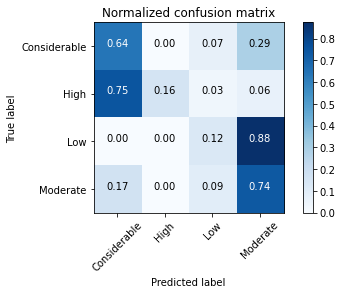

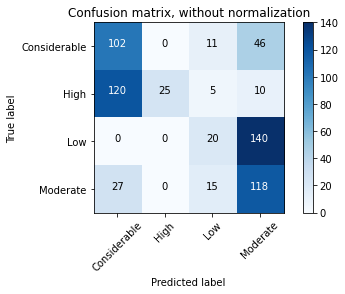

In [65]:
import numpy as np
cnf_matrix = confusion_matrix(y_test.iloc[X_test_df.index]['Day1DangerAboveTreeline'], result)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

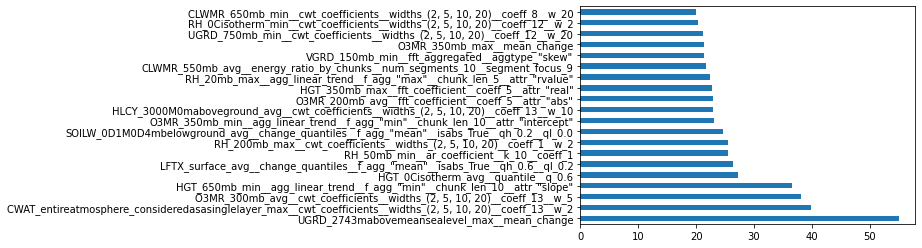

In [66]:
pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)[:20].plot.barh()